# Random Forest (Python)
Yang Xi <br>
22 Nov, 2018


<br>

- Example: Classification with Imbalanced Class
    - Tune Optimal Parameters Through Cross-Validation
    - Train Performance
    - Variable Importance and Partial Plots
    - Test Performance


# Example: Classification with Imbalanced Class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

dfTrain0 = pd.read_csv("../../data/(2016 UCI) Credit Default/data_train.csv")
dfTest0 = pd.read_csv("../../data/(2016 UCI) Credit Default/data_test.csv")

def prepTrainTest(df):
    df = pd.get_dummies(df, columns=['Default', 'Sex', 'Marriage'], drop_first=True)
    df = pd.get_dummies(df, columns=['Education', 'SepRepayment']).drop(['Education_high school', 'SepRepayment_paid'], axis=1)
    return df
dfTrain = prepTrainTest(dfTrain0)
XTrain = dfTrain.drop('Default_1',axis=1)

yTrain = dfTrain['Default_1']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Tune Optimal Parameters Through Cross-Validation
- Number of estimators num.trees in random forest is usually in scale of hundreds. It is commonly tuned first, while I will skip tuning this parameter and use a fixed number instead.
    - Here I will tune number of features to sample `max_features` and max depth of single tree `max_depth`
    - `max_features` is usually default to floor(number of features/3)
    - `max_depth` can lead to strong overfitting if too large
- To see progress, set `verbose=2`

Optimal max_features value = 6
Optimal max_depth value = 6
CV f1 score with optimal max_features value = 0.533


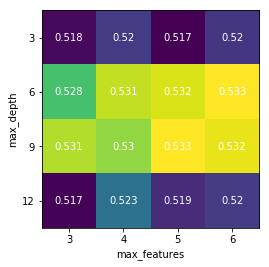

In [2]:
rangeMaxFeatures = np.floor(np.arange(dfTrain.shape[1]/3-1, dfTrain.shape[1]/3+3)).astype(int).tolist()
rangeMaxDepth = np.linspace(3, 12, 4).astype(int).tolist()
rfGS = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                           class_weight='balanced'),
                      param_grid = [{'max_features': rangeMaxFeatures,
                                     'max_depth': rangeMaxDepth}],
                      scoring = make_scorer(f1_score, greater_is_better=True),
                      cv=10, verbose=0)
rfGS.fit(XTrain, yTrain)

# Plot tuning results
cvResults = np.array(rfGS.cv_results_['mean_test_score']).reshape(len(rangeMaxDepth), len(rangeMaxFeatures))

fig, ax = plt.subplots()
im = ax.imshow(cvResults)
ax.set_xticks(np.arange(len(rangeMaxFeatures)))
ax.set_xticklabels(rangeMaxFeatures)
ax.set_xlabel('max_features')
ax.set_yticks(np.arange(len(rangeMaxDepth)))
ax.set_yticklabels(rangeMaxDepth)
ax.set_ylabel('max_depth')
for i in range(len(rangeMaxDepth)):
    for j in range(len(rangeMaxFeatures)):
        text = ax.text(j, i, round(cvResults[i, j],3),
                       ha="center", va="center", color="w")

print('Optimal max_features value = {0}'.format(rfGS.best_params_['max_features']))
print('Optimal max_depth value = {0}'.format(rfGS.best_params_['max_depth']))
print('CV f1 score with optimal max_features value = {0:.3f}'.format(rfGS.best_score_))

### Variable Importance and Partial Plots
**Variable Importance**

In [3]:
rfFit = rfGS.best_estimator_

rfVarImp = pd.DataFrame(rfFit.feature_importances_,
                        index=XTrain.columns, columns=['importance']).sort_values('importance', ascending=False)
print(rfVarImp)

                        importance
SepRepayment_2m+ delay    0.546785
SepPay                    0.093346
CreditLimit               0.092661
SepRepayment_1m delay     0.090000
AugPay                    0.067433
AugBill                   0.047508
SepBill                   0.044781
Age                       0.011810
Education_graduate        0.001799
Marriage_single           0.001671
Sex_M                     0.001397
Education_university      0.000808


**Partial Dependency Plot (PDP)**<br>
As `plot_partial_dependence` from `sklearn` support Gradient Boosting model only, alternative module will be used

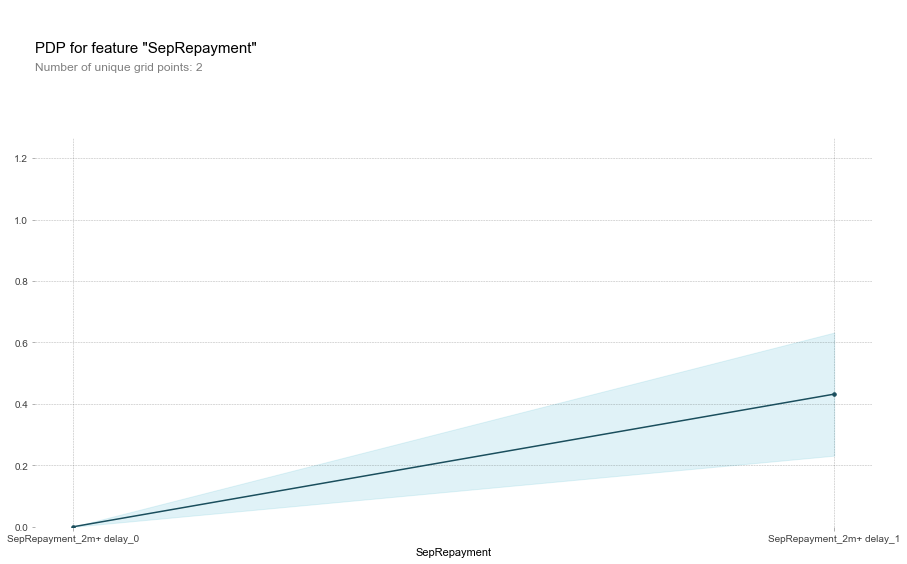

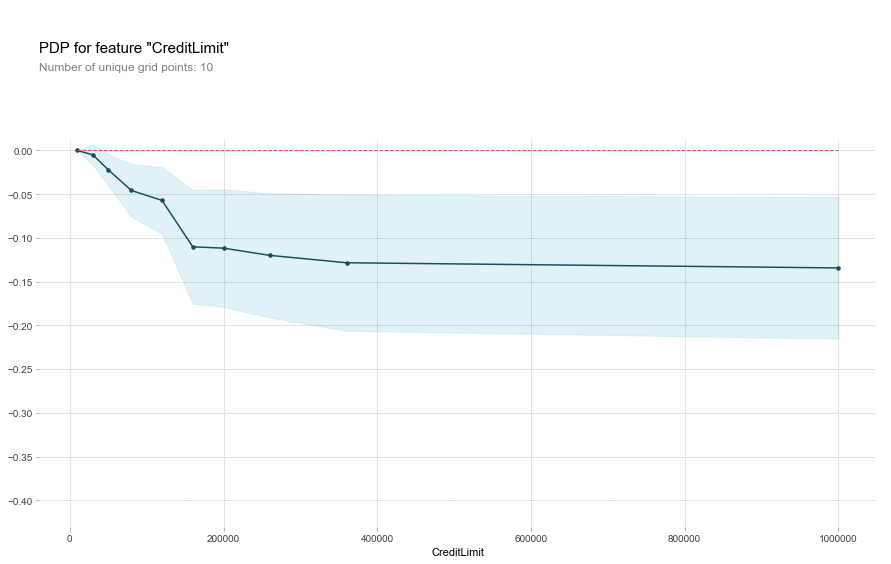

In [4]:
from pdpbox import pdp

# PDP of feature `SepRepayment_2m+ delay`
pdpSepRepayment = pdp.pdp_isolate(
    model=rfFit, dataset=dfTrain, model_features=XTrain.columns,
    feature='SepRepayment_2m+ delay'
)
fig, axes = pdp.pdp_plot(pdpSepRepayment, 'SepRepayment')

# PDP of feature `CreditLimit`
pdpCreditLimit = pdp.pdp_isolate(
    model=rfFit, dataset=dfTrain, model_features=XTrain.columns,
    feature='CreditLimit'
)
fig, axes = pdp.pdp_plot(pdpCreditLimit, 'CreditLimit')


### Train Performance

In [5]:
probTrain = [x[1] for x in rfFit.predict_proba(XTrain)]
predTrain = rfFit.predict(XTrain)

cmTrain = pd.DataFrame(confusion_matrix(yTrain, predTrain))
cmTrain.columns = pd.Series(cmTrain.columns).apply(lambda s: 'pred'+str(s))
cmTrain.index = pd.Series(cmTrain.index).apply(lambda s: 'actual'+str(s))
cmTrain

perfTrain = pd.DataFrame({'F1':[round(f1_score(yTrain, predTrain), 3)],
                          'AUC':[round(roc_auc_score(yTrain, probTrain),3)]})
print(perfTrain)

     F1    AUC
0  0.55  0.788


### Test Performance

In [6]:
dfTest = prepTrainTest(dfTest0)
XTest = dfTest.drop('Default_1',axis=1)
yTest = dfTest['Default_1']
    
predTest = rfFit.predict(XTest)

cmTest = pd.DataFrame(confusion_matrix(yTest, predTest))
cmTest.columns = pd.Series(cmTest.columns).apply(lambda s: 'pred'+str(s))
cmTest.index = pd.Series(cmTest.index).apply(lambda s: 'actual'+str(s))
cmTest

f1Test = f1_score(yTest, predTest)
print('Test f1 score = {0:.3f}'.format(f1Test))

Test f1 score = 0.518
